# Timeseries analysis of Reddit sentiment data and spy prices

In [1]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import numpy as np
import pandas as pd
import csv
import time
import datetime
import warnings 
warnings.filterwarnings("ignore")

In [2]:
# import data
df = pd.read_csv('daily_sentiment.csv', parse_dates=['date'], index_col=False)
df

,spy,date,sent
0,269.115723,2018-08-10,-9.8812
1,267.804230,2018-08-15,-17.0701
2,271.501343,2018-08-20,-0.7095
3,271.615356,2018-08-23,5.1418
4,275.407410,2018-08-27,-3.4124
...,...,...,...
481,417.940002,2021-05-10,-26.9461
482,414.209991,2021-05-11,-5.6240
483,405.410004,2021-05-12,-32.2943
484,410.279999,2021-05-13,-0.2195


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   spy     486 non-null    float64       
 1   date    486 non-null    datetime64[ns]
 2   sent    486 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 11.5 KB


In [4]:
df.describe()

,spy,sent
count,486.000000,486.000000
mean,314.837299,-3.158943
std,48.482467,14.476494
min,219.431061,-43.698100
25%,275.836182,-12.657500
50%,304.966934,-3.286300
75%,352.475662,5.691575
max,422.119995,46.818000


### Reduce noise in the sentiment score with fourier transform
For this I will transform the sentiment score into the frequency spectrum, find out highs and low, and convert it back into the time spectrum. This will remove noise from the sentiment score and allows us to spot actual patterns.

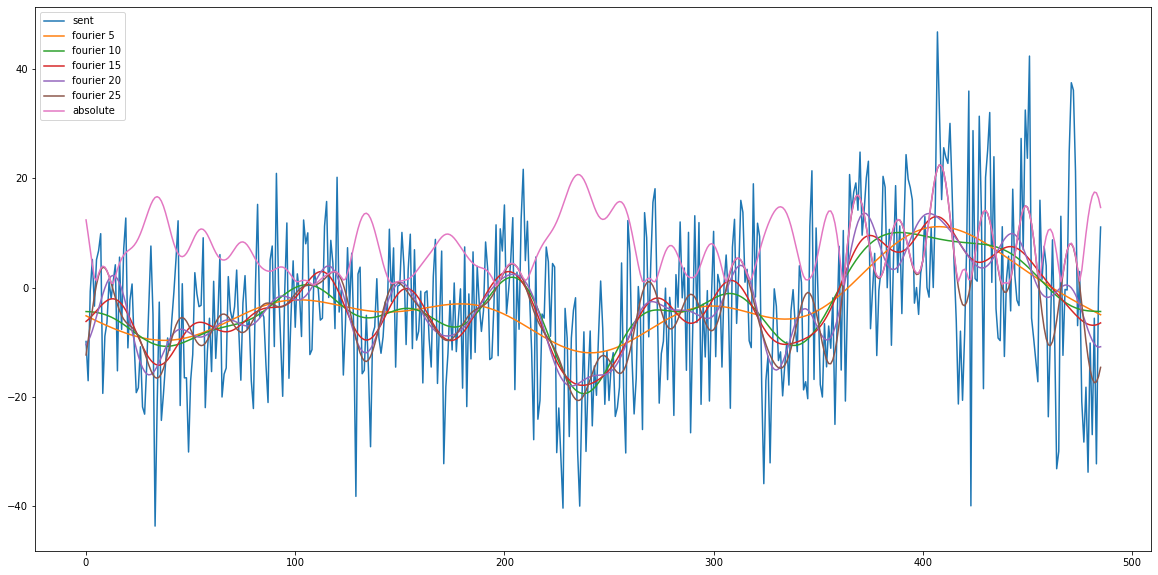

In [5]:
# extract sentiment score as a discrete fourier transform
price_fourier = np.fft.fft(np.asarray(df['sent'].tolist())) # convert sentiment to FFT with numpy
fourier_df = pd.DataFrame({'fourier':price_fourier}) # add to a dataframe
fourier_list = np.asarray(fourier_df['fourier'].tolist())  # extract fourier score as array


for num_ in range(5,30,5):
    fourier_list_m10= np.copy(fourier_list); fourier_list_m10[num_:-num_]=0 # compund fourier to smoothen signal
    # transform back into time spectrum append each fourier to dataframe with name of fourier
    df['fourier '+str(num_)]=np.fft.ifft(fourier_list_m10) 
    
# adding an absolute number of the fourier transform:
df['absolute'] = df['fourier 25'].apply(lambda x: np.abs(x))

    
# plotting sentiment score and fourier transformed scores with different compounds
df[['sent', 'fourier 5', 'fourier 10', 'fourier 15', 'fourier 20', 'fourier 25', 'absolute']].plot(figsize=(20, 10));


### The Fourier with 25 compunds seems to be reacting the stringest, so I will continue with this one

In [ ]:
# plot price vs fourier 25
df[['spy', 'fourier 25', ]].plot(secondary_y='fourier 25', figsize=(20, 10));

### You can already see that there is an interesting correlation appearing here.
The appears a spread of high sentiment and prices that are starting to fall. So one interesting approach to using sentiment score for trading could be to exploit that spread. If sentiment starts going lower, but prices keep going up, you could open a short sell position. This pattern appeared most dominently tight before the corona crash, around 225 on the X axis.

Another strategy could be exploiting overextenden negative sentiment and buying whenever peopl are panicing.
This is also a common trading stragey, but has the issue that an investore seldom know the peak of panic and therefore mistimes their trades

First, let's look at seasonailty of sentiment that could be used for trading.
Afterwards I will take a look at how the spread could be exploited

### Let's see if there's similar pattern for daily returns rather than price

In [ ]:
df[['return %', 'fourier 25', ]].plot(secondary_y='fourier 25', figsize=(20, 10));

#### There is no visible correlation between the daily returns and the sentiment of reddit, except when sharp movements in returns occur
***

In [ ]:
# Prepare data, extracting year, month, week and weekday in seperate columns
df['year'] = [d.year for d in df.date] # year
df['month'] = [d.strftime('%b') for d in df.date] # month
df['week'] = df['date'].dt.week # week number
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'} # prepare weekday
df['weekday'] = df['date'].dt.dayofweek.map(dayOfWeek) # create weekday
years = df['year'].unique() # fill in years
# create return column for spy prices
df['return %']= ((df['spy'][:-1].values / df['spy'][1:] - 1) *100) # caluclate daily returns

# export to csv for later use
df.to_csv('timeseries.csv', index=False)
df

In [ ]:
# Generate random colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

In [ ]:
# Draw Plot
plt.figure(figsize=(15,10), dpi=80)

for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'fourier 20',data=df.loc[df.year==y, :], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'fourier 20'][-1:].values[0], y, fontsize=12, color=mycolors[i])
        
plt.gca().set(ylabel='Sentiment Score', xlabel='Month')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Reddit Sentiment Scores", fontsize=20)
plt.show()        

#### The highest sentiment score generally appear in the end and the beginning of the year. 
A sharp decline happens in the summer months of june and july. This matches the general market behaviour, most professional traders and retail investors are on vacation some time over the summer, while bonusses get often paid out around the end of the year, leading to more people that invest

### Boxplot of seasonal score distribution

# Draw Plot

Below I will draw plots that aggregate the sentiment score on a yearly, monthly, weekly and weekday basis and see if I can spot pattern

In [ ]:
# Draw yearly and monthtly plots
sn.set_style("whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(25,30), dpi= 80)

sn.boxplot(x='year', y='fourier 25',palette="Blues",data=df, ax=axes[0]);
sn.boxplot(x='month', y='fourier 25', palette="Blues", data=df.loc[~df.year.isin([2018, 2021]), :]);

# Set Titles
plt.rcParams["axes.labelsize"] = 20
axes[0].set_title('Year-wise Box Plot', fontsize=20); 
axes[1].set_title('Month-wise Box Plot', fontsize=20);
axes[0].set(xlabel='Year', ylabel='Sentiment')
axes[1].set(xlabel='Month', ylabel='Sentiment')

plt.show();

### Trends visibile in yearly and monthly plots:
* Over the course of the years, sentiment increased. This is likely due to more market participants enterin in the timeframe 2019-2021
* The highest sentiment frequently appears at the end of the year. This could be due to yearly bonuses getting paid out in November/December.
* There's seasonal drop appearing in september, when the summer ends. It is also wll known under traders that september is usually the month with the lowest returns, since the summer ends, and most market participants are prepareing for the year end rallys

In [ ]:
#Draw weekly and weekday plota
sn.set_style("whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(25,30), dpi= 80)

sn.boxplot(x='week', y='fourier 25',palette="Blues",data=df, ax=axes[0]);
sn.boxplot(x='weekday', y='fourier 25', palette="Blues", data=df.loc[~df.year.isin([2018, 2021]), :]);

# Set Titles
plt.rcParams["axes.labelsize"] = 20
axes[0].set_title('Week-wise Box Plot', fontsize=20); 
axes[1].set_title('Day-wise Box Plot', fontsize=20);
axes[0].set(xlabel='Week', ylabel='Sentiment')
axes[1].set(xlabel='Weekday', ylabel='Sentiment')

plt.show();

### Trends visibile in weekly and weekday plots:
* Sentimnent varies a lot on individual weekdays. There seems to be no trends in weekdays, so buying every monday and selling every friday doesn't make sense according to the data
* On the weekly level we can clearly see that there is two seasonal drops in sentiment happening: One around week 14 in the beginning of April, and another one around week 38-43, which is mid September until mid of October

In [ ]:
## Now doing the same for price returns
# Draw yearly and monthtly plots
sn.set_style("whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(25,30), dpi= 80)

sn.boxplot(x='month', y='return %',palette="Blues",data=df, ax=axes[0]);
sn.boxplot(x='week', y='return %', palette="Blues", data=df.loc[~df.year.isin([2018, 2021]), :]);

# Set Titles
plt.rcParams["axes.labelsize"] = 20
axes[0].set_title('Month-wise Box Plot', fontsize=20); 
axes[1].set_title('Week-wise Box Plot', fontsize=20);
axes[0].set(xlabel='Year', ylabel='Sentiment')
axes[1].set(xlabel='Month', ylabel='Sentiment')

plt.show();

## Strategy One: Exploit spread between SPY price and sentiment
The first trading strategy would be to exploit the spread between the positive/negative sentiment data. 

For example, if the sentiment starts to drop into the negative, but SPY prices keep rising, then this *could* be a indicatior to open a short position and bet on lower prices in the future. 
Looking at the above plots, this pattern emerges a few times, most obviousöy right before the COVID-19 crash in march 2020. 

To implement this strategy, I use the rolling correlation between the sentiment and SPY price. 

Instead of using the raw sentiment data I use the less noisy Fourier transform with 25 components. 

I first check the correlation between the SPY prices and the 25 component Fourier transform of the sentiment data.

In [ ]:
df[['fourier 25', 'spy']].corr()

In [ ]:
# Create a dataframe with the rolling correlation using a window of 14 days. 
# I also save the actual correlation, the mean of the rolling correlation, 
# and the standard deviation of the rolling correlation as variables.

rolling_corr=df['spy'].rolling(window=14).corr(df['fourier 25'])
corr=df[['fourier 25', 'spy']].corr().iloc[0, 1]

mean=rolling_corr.mean()
print(mean)

std=np.std(rolling_corr)
print(std)